In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
vgg = models.vgg19(pretrained=True).features
for para in vgg.parameters():
  para.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
device = torch.device('cuda')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
content_img = Image.open('/content/IMG_20190203_131621.jpg').convert('RGB')
style_img = Image.open('/content/style.png').convert('RGB')

In [7]:
def transform(image):
  img_trans = transforms.Compose(
      [transforms.Resize(700),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
       
      ]
  )
  image_loader = img_trans(image)[:3,:,:].unsqueeze(0)
  return image_loader

In [8]:
np.array(content_img)

array([[[229, 240, 244],
        [229, 240, 244],
        [229, 240, 244],
        ...,
        [229, 239, 241],
        [229, 239, 240],
        [227, 239, 239]],

       [[229, 240, 244],
        [229, 240, 244],
        [229, 240, 244],
        ...,
        [227, 238, 240],
        [227, 239, 239],
        [228, 240, 240]],

       [[229, 240, 244],
        [229, 240, 246],
        [229, 240, 246],
        ...,
        [224, 238, 238],
        [228, 240, 240],
        [228, 238, 237]],

       ...,

       [[115, 180, 176],
        [118, 178, 176],
        [118, 177, 175],
        ...,
        [205, 211, 209],
        [206, 212, 210],
        [204, 209, 205]],

       [[ 78, 202, 142],
        [ 82, 201, 147],
        [ 82, 201, 147],
        ...,
        [205, 211, 207],
        [205, 211, 207],
        [202, 208, 204]],

       [[ 46, 219, 112],
        [ 52, 218, 120],
        [ 49, 214, 119],
        ...,
        [203, 212, 207],
        [201, 211, 203],
        [198, 208, 200]]

In [9]:
content_img = transform(content_img)
style_img = transform(style_img)

In [10]:
np.array(content_img)

array([[[[ 1.8036647 ,  1.8036647 ,  1.8036647 , ...,  1.7865399 ,
           1.7865399 ,  1.7694151 ],
         [ 1.8036647 ,  1.8036647 ,  1.8036647 , ...,  1.8036647 ,
           1.7522904 ,  1.8036647 ],
         [ 1.8036647 ,  1.8036647 ,  1.8036647 , ...,  1.8036647 ,
           1.8036647 ,  1.8036647 ],
         ...,
         [ 0.34806067,  0.3651854 ,  0.39943492, ...,  1.4440448 ,
           1.3926706 ,  1.3755459 ],
         [ 0.09118938,  0.10831413,  0.2281874 , ...,  1.4440448 ,
           1.3926706 ,  1.3755459 ],
         [-0.81642264, -0.79929787, -0.4054286 , ...,  1.3584211 ,
           1.3584211 ,  1.3584211 ]],

        [[ 2.1659663 ,  2.1659663 ,  2.1659663 , ...,  2.1659663 ,
           2.1484594 ,  2.1484594 ],
         [ 2.1659663 ,  2.1659663 ,  2.1309524 , ...,  2.1484594 ,
           2.1309524 ,  2.1484594 ],
         [ 2.1659663 ,  2.1659663 ,  2.1659663 , ...,  2.1484594 ,
           2.1309524 ,  2.1659663 ],
         ...,
         [ 0.74789923,  0.74789923

In [11]:
def image_convert(tensor):
  tensor = tensor.cpu().clone().detach()
  tensor = tensor.numpy().squeeze()
  tensor = tensor.transpose(1,2,0)
  tensor = tensor*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
  tensor = tensor.clip(0,1)
  return tensor

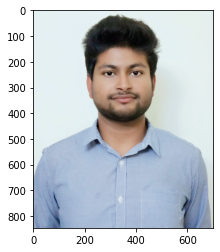

In [12]:
plt.imshow(image_convert(content_img))

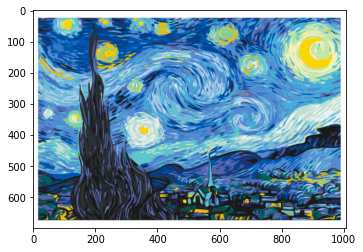

In [13]:
plt.imshow(image_convert(style_img))

In [14]:
def extract_features(image,model,layers=None):
  if layers is None:
    layers = {'0':'conv1_1','5':'conv2_1', '10':'conv3_1', '19':'conv4_1', '28':'conv5_1', '21':'conv4_2'}
    features = {}
    for name, layer in model._modules.items():
      image = layer(image)
      if name in layers:
        features[layers[name]]=image
    return features

In [15]:
def gram_matrix(tensor):
  batch_size, depth, height,width = tensor.shape
  tensor = tensor.view(depth,-1)
  tensor = torch.mm(tensor,tensor.t())
  return tensor

In [16]:
style_features = extract_features(style_img.cuda(),vgg)
content_features = extract_features(content_img.cuda(),vgg)

In [17]:
style_grams = {layer:gram_matrix(style_features[layer])for layer in style_features}

In [18]:
style_grams

{'conv1_1': tensor([[ 481297.2188,  166794.8906,  231867.6094,  ...,  328404.8438,
            77199.5000,  215555.3438],
         [ 166794.8906,  562643.0625,   56313.0508,  ...,  576155.8750,
            83964.0234,  300424.9688],
         [ 231867.6094,   56313.0508,  197514.6719,  ...,   36418.0234,
            36916.6016,   93597.5938],
         ...,
         [ 328404.8438,  576155.8750,   36418.0234,  ..., 3739287.5000,
           387298.1250,  708879.7500],
         [  77199.5000,   83964.0234,   36916.6016,  ...,  387298.1250,
           139335.7031,   90176.5938],
         [ 215555.3438,  300424.9688,   93597.5938,  ...,  708879.7500,
            90176.5938,  778425.9375]], device='cuda:0'),
 'conv2_1': tensor([[ 690525.1250,  120495.7812,  254527.7812,  ...,  574623.0625,
           152605.1719,  145738.9688],
         [ 120495.7812,  490631.0625,   78631.6562,  ...,  844573.7500,
           219930.4531,  122738.1094],
         [ 254527.7812,   78631.6562,  366711.3125,  ...,

In [19]:
target = content_img.clone().cuda().detach().requires_grad_(True)

In [20]:
[target]

[tensor([[[[ 1.8037,  1.8037,  1.8037,  ...,  1.7865,  1.7865,  1.7694],
           [ 1.8037,  1.8037,  1.8037,  ...,  1.8037,  1.7523,  1.8037],
           [ 1.8037,  1.8037,  1.8037,  ...,  1.8037,  1.8037,  1.8037],
           ...,
           [ 0.3481,  0.3652,  0.3994,  ...,  1.4440,  1.3927,  1.3755],
           [ 0.0912,  0.1083,  0.2282,  ...,  1.4440,  1.3927,  1.3755],
           [-0.8164, -0.7993, -0.4054,  ...,  1.3584,  1.3584,  1.3584]],
 
          [[ 2.1660,  2.1660,  2.1660,  ...,  2.1660,  2.1485,  2.1485],
           [ 2.1660,  2.1660,  2.1310,  ...,  2.1485,  2.1310,  2.1485],
           [ 2.1660,  2.1660,  2.1660,  ...,  2.1485,  2.1310,  2.1660],
           ...,
           [ 0.7479,  0.7479,  0.8004,  ...,  1.6758,  1.7108,  1.7283],
           [ 0.9055,  0.8880,  0.8704,  ...,  1.6583,  1.6758,  1.6758],
           [ 1.5182,  1.5182,  1.2556,  ...,  1.6408,  1.6408,  1.6408]],
 
          [[ 2.4483,  2.4483,  2.4483,  ...,  2.3786,  2.3786,  2.3786],
           [ 

In [ ]:
[content_img]

[tensor([[[[ 1.8037,  1.8037,  1.8037,  ...,  1.7865,  1.7865,  1.7694],
           [ 1.8037,  1.8037,  1.8037,  ...,  1.8037,  1.7523,  1.8037],
           [ 1.8037,  1.8037,  1.8037,  ...,  1.8037,  1.8037,  1.8037],
           ...,
           [ 0.3481,  0.3652,  0.3994,  ...,  1.4440,  1.3927,  1.3755],
           [ 0.0912,  0.1083,  0.2282,  ...,  1.4440,  1.3927,  1.3755],
           [-0.8164, -0.7993, -0.4054,  ...,  1.3584,  1.3584,  1.3584]],
 
          [[ 2.1660,  2.1660,  2.1660,  ...,  2.1660,  2.1485,  2.1485],
           [ 2.1660,  2.1660,  2.1310,  ...,  2.1485,  2.1310,  2.1485],
           [ 2.1660,  2.1660,  2.1660,  ...,  2.1485,  2.1310,  2.1660],
           ...,
           [ 0.7479,  0.7479,  0.8004,  ...,  1.6758,  1.7108,  1.7283],
           [ 0.9055,  0.8880,  0.8704,  ...,  1.6583,  1.6758,  1.6758],
           [ 1.5182,  1.5182,  1.2556,  ...,  1.6408,  1.6408,  1.6408]],
 
          [[ 2.4483,  2.4483,  2.4483,  ...,  2.3786,  2.3786,  2.3786],
           [ 

In [21]:
style_weights = {
    'conv1_1':1.0,
    'conv2_1':0.8,
    'conv3_1':0.5,
    'conv4_1':0.3,
    'conv5_1':0.1}
content_weight = 1
style_weight = 5e6

In [22]:
class CustomAdam(torch.optim.Adam):
     def step(self, closure=None):
        p.data.add_((-step_size * (exp_avg / denom)))

Total Loss: 6523520512.0
Total Loss: 3796765952.0
Total Loss: 2007491456.0
Total Loss: 1162466560.0
Total Loss: 833044864.0
Total Loss: 661336640.0
Total Loss: 540915840.0
Total Loss: 448314272.0
Total Loss: 375180128.0
Total Loss: 316832992.0
Total Loss: 270065568.0
Total Loss: 232466416.0
Total Loss: 202117056.0
Total Loss: 177527232.0
Total Loss: 157469536.0
Total Loss: 140982416.0
Total Loss: 127299848.0
Total Loss: 115833096.0
Total Loss: 106109056.0
Total Loss: 97778544.0


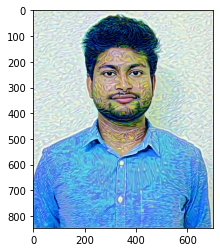

In [24]:
optimizer =  optim.Adam([target],lr=0.003)
steps = 2000
print_every = 100
for i in range(1,steps+1):
  target_features = extract_features(target,vgg)
  content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    _,d,h,w = target_feature.shape
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    style_loss+=layer_style_loss/(d*h*w)

  total_loss = style_weight*style_loss+content_weight*content_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  if i%print_every ==0:
    print("Total Loss:",total_loss.item())
    plt.imshow(image_convert(target))

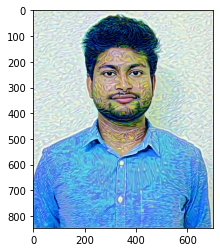

In [25]:
plt.imshow(image_convert(target))

In [ ]:
plt.imsave('style.jpg',image_convert(target))